# ISE 529 HW 5
## Session: W
## Group Members: Naichang LU, Feiyang GU, Qikai GAO, Yihang ZHANG

## Pre-processing

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics, model_selection, linear_model

In [2]:
# set random seed to 1 so that this produces result that is repeatable.
np.random.seed(1)

In [3]:
# Generating data as required
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(r' ([A-Za-z]+)\.', expand=False)

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

guess_ages = np.zeros((2,3))
guess_ages

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4
    # np.piecewise() # this author is stupid

train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

freq_port = train_df.Embarked.dropna().mode()[0]

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

In [4]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [5]:
def getScore(model, X_train, Y_train, metric=metrics.accuracy_score):
    cv = model_selection.KFold(n_splits=5)
    score = model_selection.cross_val_score(model,
            X_train,Y_train,scoring=metrics.make_scorer(metric), cv=cv)
    return score.mean()

Here are some baseline models provided in the sample answer.

We only make minor modifications to the file so that it does not throw warnings.

The scores below are test accuracy on 5-fold cross validation, so it should be lower than what is originally given.

In [6]:
model_dict = {'Support Vector Machines':SVC(gamma='auto'),
             'KNN':KNeighborsClassifier(n_neighbors = 3),
             'Logistic Regression':LogisticRegression(solver='lbfgs'),
             'Random Forest':RandomForestClassifier(n_estimators=100),
             'Naive Bayes':GaussianNB(),
             'Perceptron':Perceptron(),
             'Stochastic Gradient Descent':SGDClassifier(),
             'Linear SVC':LinearSVC(max_iter=10000),
             'Decision Tree':DecisionTreeClassifier()}

score_list = [getScore(model,X_train,Y_train)
              for model_name, model in model_dict.items()]

score_pd = pd.DataFrame({'model':list(model_dict.keys()),'Accuracy rate':score_list}) 
score_pd.sort_values(by='Accuracy rate', ascending=False)

,model,Accuracy rate
0,Support Vector Machines,0.817055
2,Logistic Regression,0.805844
3,Random Forest,0.804739
7,Linear SVC,0.794602
8,Decision Tree,0.793516
1,KNN,0.774484
4,Naive Bayes,0.763292
6,Stochastic Gradient Descent,0.754265
5,Perceptron,0.750882


## Question 2

In [7]:
from xgboost import XGBClassifier
from scipy import stats

In [8]:
X_tr,X_te,Y_tr,Y_te = model_selection.train_test_split(X_train,Y_train,test_size=0.3)

In [9]:
# To simplify workflow, we write the following function to get cross-validation score
# for specified set of hyperparameter
def tune_xgb_score(**param):
    xgb = XGBClassifier(n_estimators=param["n_estimators"],
                        max_depth=param["max_depth"], learning_rate=param["max_depth"])
    return getScore(xgb, X_tr, Y_tr)

In [10]:
# Our baseline model
tune_xgb_score(n_estimators=100, max_depth=4, learning_rate=0.01)

0.6593806451612904

In [11]:
# Smooth a curve by exponential decaying
def exp_smooth(a, smooth=0.5):
    L = []
    cur = a[0]
    for x in a:
        cur = (1-smooth) * x + smooth * cur
        L.append(cur)
    return np.array(L)

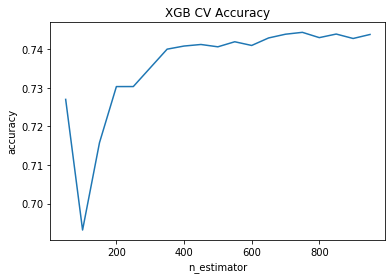

In [12]:
# Now tune the hyperparameters
n = 300
d = 4
lr = 0.01
# Acceptable range for each parameter
n_estimators_range = np.arange(50, 1000, 50)
#max_depth_range = np.arange(1, 10, 1)
#learning_rate_range = np.logspace(-5, -0.5, 20)

scores = []
for x in n_estimators_range:
    scores.append(tune_xgb_score(n_estimators=x, max_depth=d, learning_rate=lr))
plt.plot(n_estimators_range, exp_smooth(np.array(scores)))
#plt.plot(n_estimators_range, np.array(scores))

plt.xlabel("n_estimator")
plt.ylabel("accuracy")
plt.title("XGB CV Accuracy");

In [13]:
# Therefore we pick the following value for n_estimators
n = 450

In [14]:
xgb = XGBClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
xgb.fit(X_tr, Y_tr)
pred = xgb.predict(X_te)
xgb.score(X_te,Y_te)

0.8134328358208955

In [15]:
pred_proba = xgb.predict_proba(X_te)
auc = metrics.roc_auc_score(Y_te,pred_proba[:,1])
print(auc)

0.8781249999999998


In [16]:
fpr,tpr,thresholds = metrics.roc_curve(Y_te,pred_proba[:,1])

[0, 1, 0, 1]

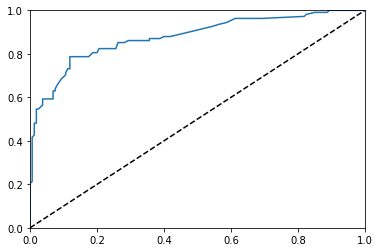

In [17]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'k--')
plt.axis([0,1,0,1])

### Conclusion: Accuracy = 0.813 AUC = 0.878


## Question 3

In [18]:
import sklearn.base
class my_ensemble_model(sklearn.base.BaseEstimator):

    def fit(self, X_train, Y_train, hold=False):
        self.models = list(model_dict.values())
        if not hold:
            for model in self.models:
                model.fit(X_train, Y_train)
        return self
            
    def predict(self, X_test):
        pred_list = np.vstack([model.predict(X_test) for model in self.models])
        mod = np.squeeze((pred_list.mean(axis=0) > 0.5).astype(int))

        return mod

In [19]:
getScore(my_ensemble_model(), X_train, Y_train)

0.8103257799259307

### The accuracy rate of the ensemble_model is 0.810.

## Question 4

In [20]:
class zero_model(sklearn.base.BaseEstimator):

    def fit(self, X_train, Y_train):
        return self
            
    def predict(self, X_test):
        x_len = X_test.shape[0]
        return np.zeros(x_len)

In [21]:
del model_dict['Stochastic Gradient Descent']

model_dict['zero']=zero_model()
getScore(my_ensemble_model(), X_train, Y_train)

0.8069487163392128

### The accuracy rate of the new ensemble_model is 0.806.

## Question 5

In [22]:
# Let's clear the models and fit new ones with
# hyperparamter selection.
for key in list(model_dict.keys()):
    del model_dict[key]

In [23]:
# First center and normalize the data as follows.
# Here are the first five lines of the processed data
X_train_scaled = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_train_scaled.head()

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0.826913,-0.737281,-0.392778,-1.346021,-0.568518,-0.707153,-1.230954,0.133785
1,-1.565228,1.354813,0.826613,1.336987,1.004617,1.234522,-1.230954,-0.436562
2,0.826913,1.354813,-0.392778,-0.451685,-0.568518,0.263684,0.811467,0.133785
3,-1.565228,1.354813,0.826613,1.336987,-0.568518,1.234522,-1.230954,-0.436562
4,0.826913,-0.737281,0.826613,-0.451685,-0.568518,-0.707153,0.811467,1.844825


In [24]:
# Cross validator
cv = model_selection.KFold(n_splits=5, random_state=1)

In [25]:
%%time
# KNN
knn_grid = {"n_neighbors" : np.arange(1, 15), "p": [1, 2], } 
knn = model_selection.GridSearchCV(KNeighborsClassifier(), knn_grid,
          scoring="accuracy", cv=cv, n_jobs=-1)
knn.fit(X_train_scaled, Y_train)
print(knn.score(X_train_scaled, Y_train))

0.8271604938271605
Wall time: 1.84 s


In [26]:
%%time
# Logistic Regression
logreg = linear_model.LogisticRegressionCV(cv=cv, max_iter=1000, random_state=1)
logreg.fit(X_train_scaled, Y_train)
print(logreg.score(X_train_scaled, Y_train))

0.813692480359147
Wall time: 110 ms


In [27]:
%%time
# SVC
svc_param_grid = {
    "kernel" : ['linear', 'rbf', 'poly'],
    "C" : np.logspace(-3, 1, 5),
    "gamma" : ["auto", "scale"],
    "degree" : np.arange(5)
}

svc = model_selection.GridSearchCV(SVC(random_state=1), svc_param_grid,
        scoring="accuracy", cv=cv, n_jobs=-1)
svc.fit(X_train_scaled, Y_train)

print(svc.score(X_train_scaled, Y_train))

0.8439955106621774
Wall time: 3.16 s


In [28]:
# XGBoost has to be manually tuned
# We split the training data to get a validation set.
X_tr, X_val, Y_tr, Y_val = model_selection.train_test_split(
    X_train_scaled, Y_train, test_size=0.3)
eval_set = ((X_tr, Y_tr), (X_val, Y_val))
eval_metric = ["auc", "error"]

In [29]:
%%time
# Using the validation set we tune the hyperparameters of XGBClassifier.
# To avoid overfitting and wasting computation, we stop after 200 trees.
xgb = XGBClassifier(scale_pos_weight=1,
                  learning_rate=0.01,  
                  colsample_bytree=0.8,
                  subsample=0.8,
                  objective='binary:logistic', 
                  n_estimators=200, 
                  reg_alpha=0.3,
                  max_depth=3, 
                  gamma=1,
                  random_state=1
                )
xgb.fit(X_tr, Y_tr, eval_metric=eval_metric, eval_set=eval_set,
          verbose=50);

[0]	validation_0-auc:0.809465	validation_0-error:0.210273	validation_1-auc:0.79573	validation_1-error:0.208955
[50]	validation_0-auc:0.866645	validation_0-error:0.170144	validation_1-auc:0.862723	validation_1-error:0.175373
[100]	validation_0-auc:0.868636	validation_0-error:0.170144	validation_1-auc:0.870106	validation_1-error:0.16791
[150]	validation_0-auc:0.869665	validation_0-error:0.17175	validation_1-auc:0.873741	validation_1-error:0.171642
[199]	validation_0-auc:0.873587	validation_0-error:0.17175	validation_1-auc:0.87334	validation_1-error:0.171642
Wall time: 89 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [30]:
# After that we use the hyperparameters and fit on the whole training set.
xgb.fit(X_train_scaled, Y_train)
print(xgb.score(X_train_scaled, Y_train))

0.8305274971941639


In [31]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_scaled, Y_train);

In [32]:
# We ensemble these three methods, and do not refit.
model_dict = {
    "knn": knn,
    "xgb": xgb,
    "logreg": logreg,
    "svc": svc,
    "random forest": rfc
}
model = my_ensemble_model().fit(X_train_scaled, Y_train, hold=True)

In [33]:
# Now scale the test data along with the training data.
# Here are the first five row of the transformed test data.
X_combine = pd.concat([X_train, X_test])
X_test_scaled = (X_test - X_combine.mean(axis=0)) / X_combine.std(axis=0)
X_test_scaled.head()

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0.841595,-0.743213,0.844713,-1.331338,2.457243,-0.716789,0.810222,1.968703
1,0.841595,1.344482,0.844713,-1.331338,-0.603205,1.239992,-1.233286,1.968703
2,-0.351956,-0.743213,2.089905,-0.444005,2.457243,-0.716789,0.810222,1.968703
3,0.841595,-0.743213,-0.400478,-0.444005,-0.603205,-0.716789,0.810222,0.160259
4,0.841595,1.344482,-0.400478,-0.444005,-0.603205,1.239992,-1.233286,0.160259


In [34]:
# Last we use our ensemble model to make predictions.
pred = model.predict(X_test_scaled)

In [35]:
# We assemble the predictions in order to make submission to kaggle.
submission = pd.DataFrame(
    {
        "PassengerID": test_df["PassengerId"],
        "Survived": pred
    }
)
submission.head()

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [36]:
submission.to_csv("submission.csv", index=False)

In [37]:
# Done!

### Conslusion: With the latest submission to Kaggle under team name "miaonima" at 12:10 pm 11/19/2019, the score for public test is 0.79904. 